In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import warnings
warnings.filterwarnings('ignore')
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.util import ngrams
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# reading dataset
data = pd.read_csv('news.csv')
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
# taking text column only
# bcoz i want make prediction with text only

data = data[['text','label']]
data.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [4]:
# checking info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6335 non-null   object
 1   label   6335 non-null   object
dtypes: object(2)
memory usage: 99.1+ KB


In [5]:
data.shape

(6335, 2)

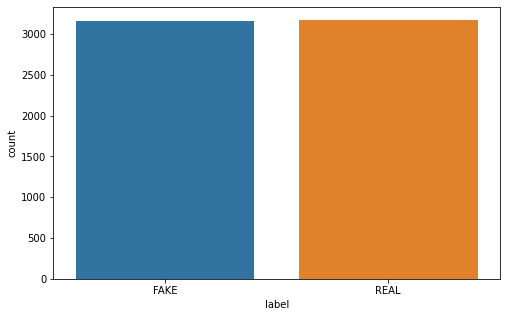

In [6]:
# plotting output column 
plt.figure(figsize = (8,5))
sns.countplot(data['label'])
plt.show()
# its a balanced dataset

### Data Cleaning and Pre-Processing

In [7]:
data.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [8]:

def clean_text(text):
    lemmatizer = WordNetLemmatizer()
    stopwords_english = stopwords.words('english')
    text= re.sub('\[[^]]*\]', '', text)
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    #removal of html tags
    review =re.sub(r'<.*?>',' ',text) 
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove hashtags
    text = re.sub(r'#', '', text)
    
    # removing other non-alphabetical characters
    text = re.sub('[^a-zA-Z]',' ',text) 
    text = text.lower()
    text_tokens =word_tokenize(text)

    text_clean = []
    for word in  text_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            lem_word =lemmatizer.lemmatize(word)  # lemmitizing word
            text_clean.append(lem_word)
    text_mod=[i for i in text_clean if len(i)>2]
    text_clean=' '.join(text_mod)
    return  text_clean


In [9]:
data['clean_text']=data['text'].apply(lambda x: clean_text(x))
data.drop(columns = ['text'], inplace = True)

In [10]:
data.head()

,label,clean_text
0,FAKE,daniel greenfield shillman journalism fellow f...
1,FAKE,google pinterest digg linkedin reddit stumbleu...
2,REAL,secretary state john kerry said monday stop pa...
3,FAKE,kaydee king kaydeeking november lesson tonight...
4,REAL,primary day new york front runner hillary clin...


### Counting Frequency of N-grams

In [11]:
df=' '.join([sentance for sentance in data['clean_text']])

In [12]:
# Function to generate n-grams from sentences.

def extract_ngrams(data, num):
    n_grams = ngrams(nltk.word_tokenize(data), num)
    return [ ' '.join(grams) for grams in n_grams]
 
unigrams = extract_ngrams(df, 1)
bigrams  = extract_ngrams(df, 2)
trigrams = extract_ngrams(df, 3)
fourgrams= extract_ngrams(df, 4)

In [13]:
uni_freq = nltk.FreqDist(unigrams)
bi_freq = nltk.FreqDist(bigrams)
tri_freq = nltk.FreqDist(trigrams)
four_freq = nltk.FreqDist(fourgrams)

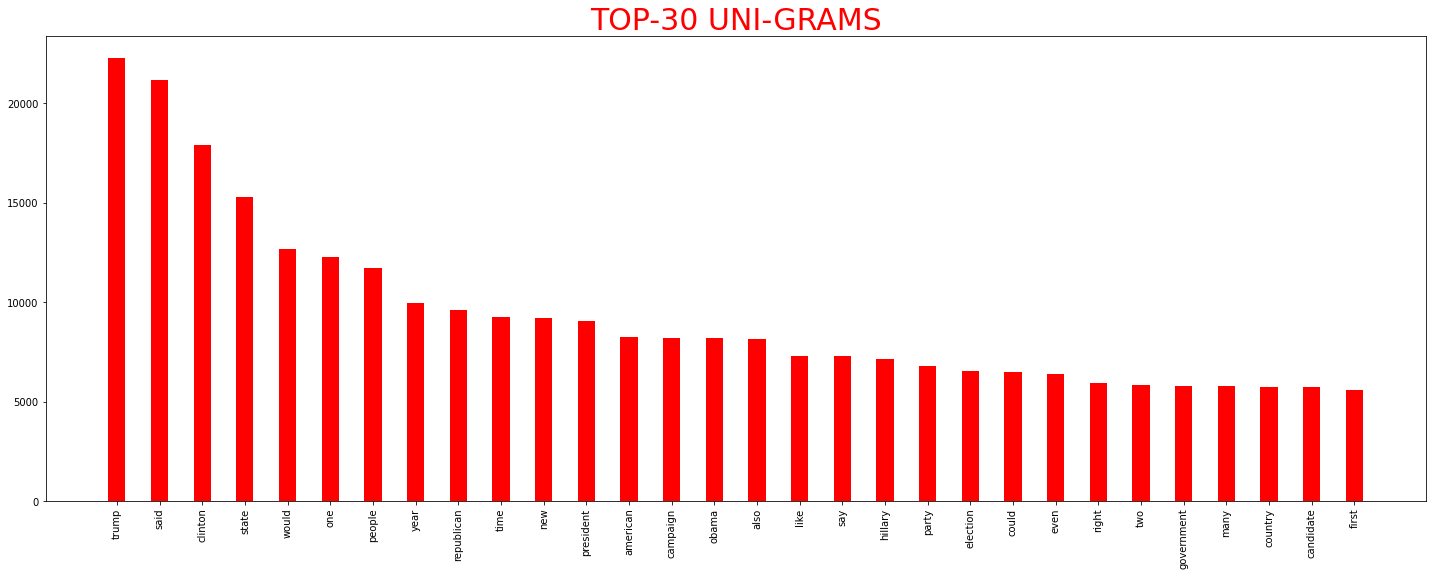

In [14]:
# top 20 uigrams
top_20_uni=uni_freq.most_common(30)
top_20_uni_words,top_20_uni_freq=list(zip(*top_20_uni))
plt.figure(figsize=(20,7))
plt.bar(top_20_uni_words, top_20_uni_freq, color ='red',
        width = 0.4)
plt.tight_layout()
plt.title('TOP-30 UNI-GRAMS', color = 'red', size = 30)
plt.xticks(rotation = 90)
plt.show()

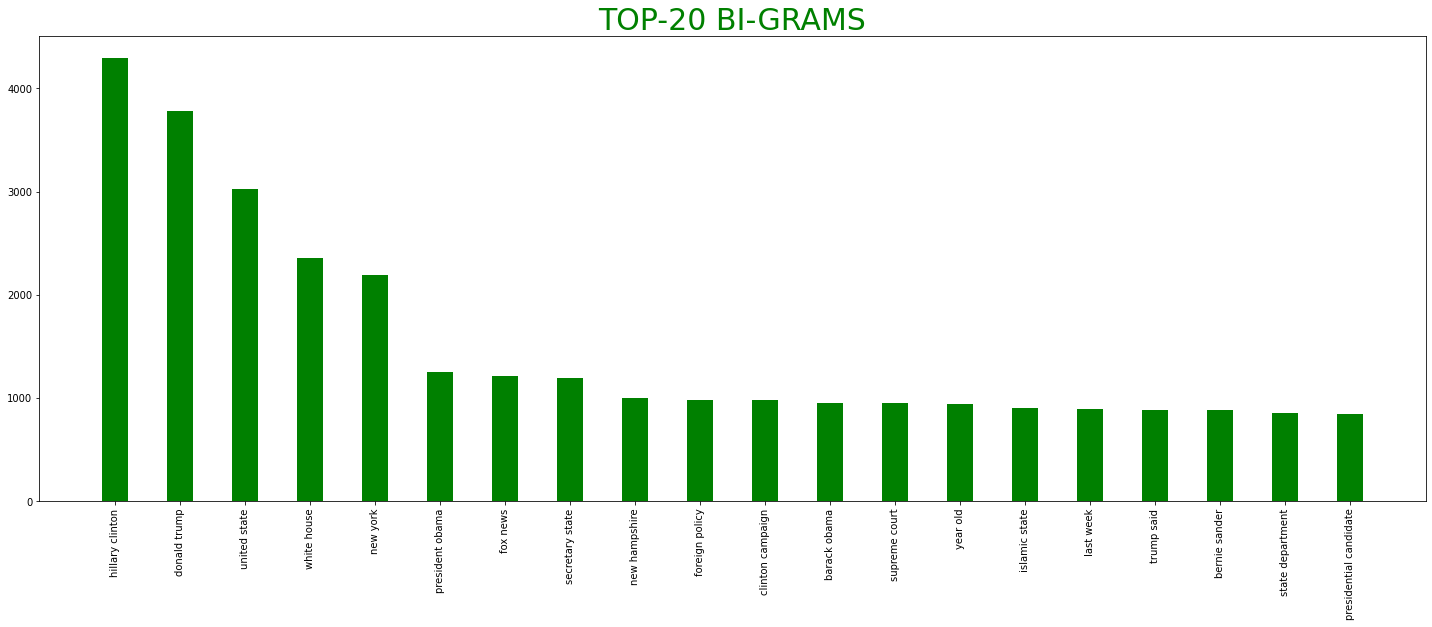

In [15]:
# top 20 bi-grams
top_20_bi=bi_freq.most_common(20)
top_20_bi_words,top_20_bi_freq=list(zip(*top_20_bi))
plt.figure(figsize=(20,7))
plt.bar(top_20_bi_words, top_20_bi_freq, color ='green',
        width = 0.4)
plt.tight_layout()
plt.title('TOP-20 BI-GRAMS', color = 'green', size = 30)
plt.xticks(rotation = 90)
plt.show()

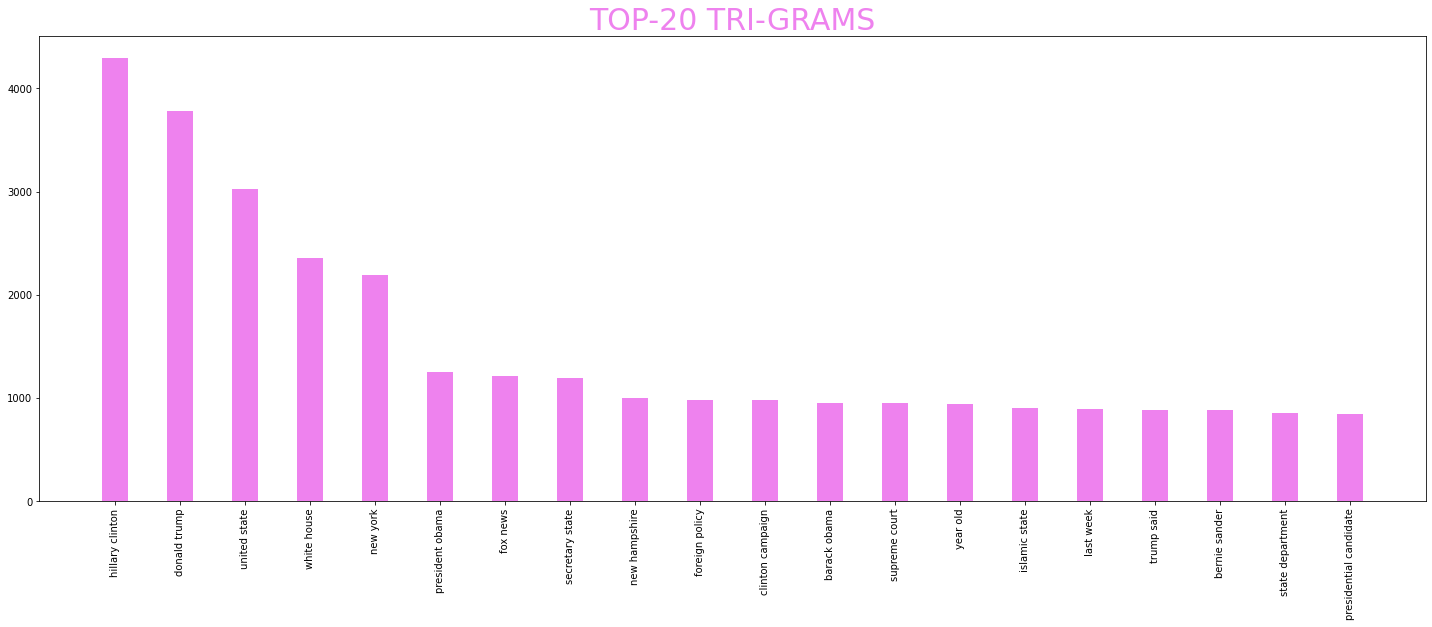

In [16]:
# top 20 tri-grams
top_20_tri=tri_freq.most_common(20)
top_20_tri_words,top_20_tri_freq=list(zip(*top_20_bi))
plt.figure(figsize=(20,7))
plt.bar(top_20_tri_words, top_20_tri_freq, color ='violet',
        width = 0.4)
plt.tight_layout()
plt.title('TOP-20 TRI-GRAMS', color = 'violet', size = 30)
plt.xticks(rotation = 90)
plt.show()

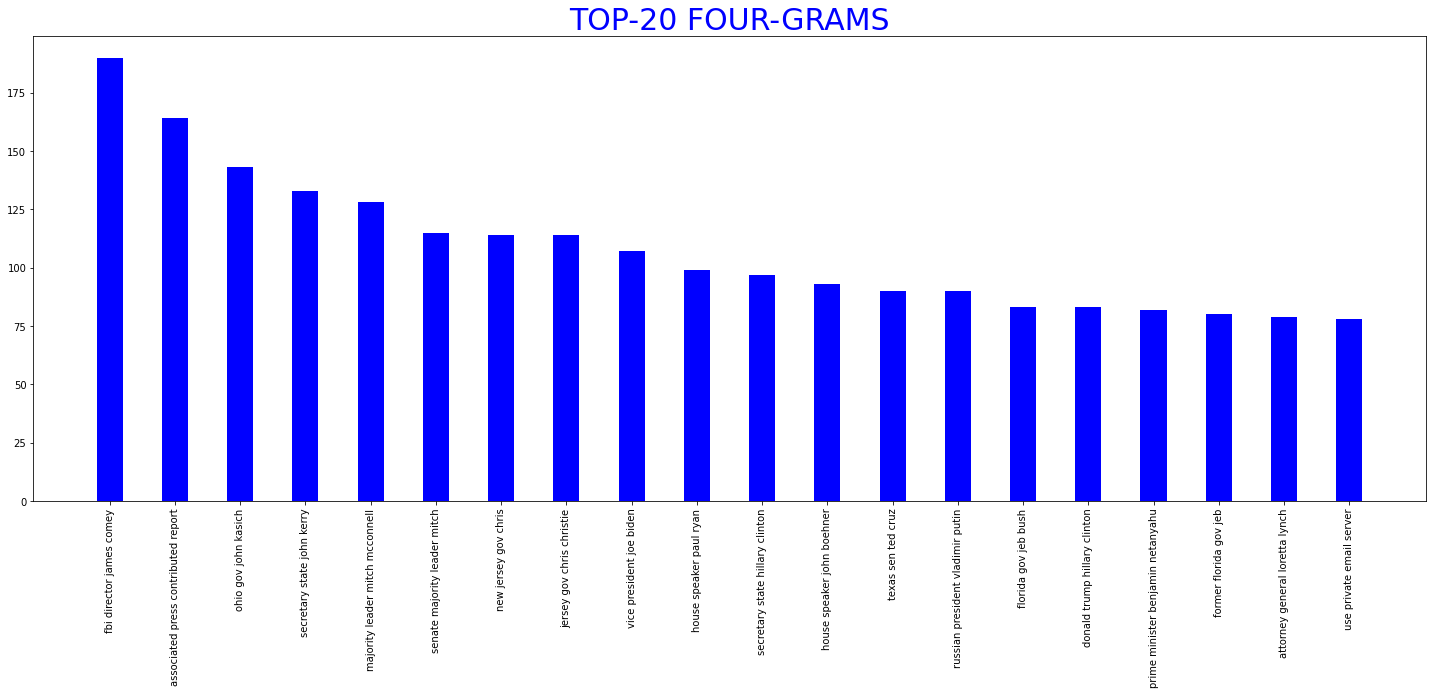

In [17]:
# top 20 four-grams

top_20_four=four_freq.most_common(20)
top_20_four_words,top_20_four_freq=list(zip(*top_20_four))
plt.figure(figsize=(20,7))
plt.bar(top_20_four_words, top_20_four_freq, color ='blue',
        width = 0.4)
plt.tight_layout()
plt.title('TOP-20 FOUR-GRAMS', color = 'blue', size = 30)
plt.xticks(rotation = 90)
plt.show()

In [19]:
data.head()

,label,clean_text
0,FAKE,daniel greenfield shillman journalism fellow f...
1,FAKE,google pinterest digg linkedin reddit stumbleu...
2,REAL,secretary state john kerry said monday stop pa...
3,FAKE,kaydee king kaydeeking november lesson tonight...
4,REAL,primary day new york front runner hillary clin...


In [25]:
data['label'].replace(['FAKE','REAL'],[1,0],inplace = True)

In [48]:
data.head()

,label,clean_text
0,1,daniel greenfield shillman journalism fellow f...
1,1,google pinterest digg linkedin reddit stumbleu...
2,0,secretary state john kerry said monday stop pa...
3,1,kaydee king kaydeeking november lesson tonight...
4,0,primary day new york front runner hillary clin...


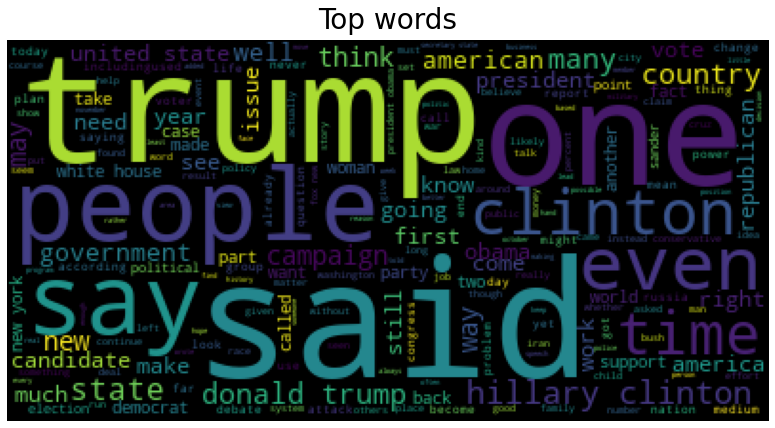

In [47]:

wc = WordCloud(
    background_color='black', 
    max_words=200)

wc.generate(' '.join(text for text in data.loc[:, 'clean_text']))
plt.figure(figsize=(15,7))
plt.title('Top words', 
          fontdict={'size': 28,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [82]:
# spliting data into train and test

feature = data['clean_text']
label   = data['label']

xtrain,xtest,ytrain,ytest = train_test_split(feature, label, random_state = 42, test_size = 0.2)

In [73]:
vectorizer = TfidfVectorizer(analyzer = 'word', stop_words = 'english', max_features = 5000)
train_data = vectorizer.fit_transform(X_train)
# vectorizer.get_feature_names()

In [83]:
# using Tfidf-Vectorizer and Applying LogisticRegression Algo.

tfidf = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfidf_text = tfidf.fit_transform(list(xtrain)+list(xtest))
tfidf_xtrain = tfidf.transform(xtrain)
tfidf_xtest = tfidf.transform(xtest)

lr = LogisticRegression().fit(tfidf_xtrain,ytrain)
preds = lr.predict(tfidf_xtest)
print(cross_val_score(lr,tfidf_xtest,ytest,cv = 5))
print(accuracy_score(preds,ytest))

[0.8976378  0.92125984 0.88537549 0.91304348 0.91304348]
0.9242304656669298


In [118]:
# single Prediction Function that do all the Process

def Prediction(feature_data):
    
    text = re.sub('\[[^]]*\]', '', feature_data)
    
    text = re.sub(r'\$\w', '',text)
    
    text = re.sub(r'<.*?>', ' ', text)
    
    text = re.sub(r'http?:\/\/.*[\r\n]*', '',text)
    
    text = re.sub(r'#', '',text)
    
    text = re.sub('[^a-zA_Z]','',text)
    
    text = text.lower()
    text_tokens = word_tokenize(text)
    
    text_clean = []
    lemmatizer = WordNetLemmatizer()
    stopwords_english = stopwords.words('english')
    
    for word in text_tokens:
        if (word not in stopwords_english and word not in string.punctuation):
            lem_word = lemmatizer.lemmatize(word)
            text_clean.append(lem_word)
    text_mod = [i for i in text_clean if len(i)>2]
    text_clean = [' '.join(text_mod)]
#     print(text_clean)
    
    tfidf = TfidfVectorizer(min_df=1.0,  max_features=None, max_df = 1.0,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

    tfidf_xtrain = tfidf.fit_transform(text_clean)
    preds = lr.predict(tfidf_xtest)
    print(cross_val_score(lr,tfidf_xtest,ytest,cv = 5))
    print(accuracy_score(preds,ytest))

In [119]:
# data['clean_text'].values[0]